# Clasificación de Gatos y Perros

## Bibliotecas

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers
from tensorflow.keras.models import Sequential , Model
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from glob import glob
from PIL import Image

import os
import shutil

tf.random.set_seed(42)

print('TF Version:', tf.__version__)

TF Version: 2.18.0


**¿Tenemos GPUs disponibles?** en caso afirmativo, la vamos a utilizar

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

Num GPUs Available:  1


In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    pass

Mounted at /content/drive


## Utilidades

In [21]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


In [22]:
def get_predictions(model, test_images, test_labels):
    """
    Get predictions from the model on the test dataset.
    """
    predictions = model.predict(test_images)
    return test_labels, predictions.ravel()

def plot_confusion_matrix(y_true, predictions, target_names):
    """
    Plot the confusion matrix and classification report.
    """

    # Convertimos las predicciones a 0 o 1 dependiendo de si son mayores o menores que 0.5
    # Esto es necesario porque la salida de la red neuronal es un valor entre 0 y 1,
    # y queremos convertirlo a una clase (0 o 1) 0 para gato y 1 para perro
    y_pred = np.where(predictions > 0.5, 1, 0)

    cm = confusion_matrix(y_true, y_pred)
    print("Classification Report on Test Data 1")
    print(classification_report(y_true, y_pred, target_names=target_names))
    print()
    print("Confusion Matrix on Test Data 1")
    print(pd.DataFrame(cm))


In [24]:
results = pd.DataFrame(columns=["model", "accuracy", "loss", "recall", "precision"])

def save_results(model, y_true, y_pred, results):
    """
    Save the model results to dataframe.
    """

    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred).numpy().mean()

    y_pred = np.where(y_pred > 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred).numpy()
    precision = tf.keras.metrics.Precision()(y_true, y_pred).numpy()

    new_row = pd.DataFrame([{
        "model": model.name,
        "accuracy": accuracy,
        "loss": loss,
        "recall": recall,
        "precision": precision
    }])

    if results.empty:
        return new_row
    else:
        # Append the new row to the existing DataFrame
        results = pd.concat([results, new_row], ignore_index=True)
        return results


## Carga de datos

In [6]:
# Definimos el tamaño de la imagen y el batch size (se puede cambiar dependiendo de la GPU)
NX = 128
NY = 128
IMG_DIMS = (NX, NY)
BATCH_SIZE = 32
IMG_SHAPE = (NX, NY, 3)
NBATCHES = 50

# Definimos las clases de la imagen
CLASSES = ['Cat', 'Dog']

# Definimos la carpeta donde se encuentran las imagenes
# folder
#    ├── Train
#    │   ├── Cat
#    │   └── Dog
#    ├── Val
#    │   ├── Cat
#    │   └── Dog
#    └── Test
#        ├── Cat
#        └── Dog
# Verificamos si estamos en Google Colab y ajustamos la ruta del directorio en consecuencia
if 'google.colab' in str(get_ipython()):
    folder = "/content/drive/MyDrive/Data_PDIS/Cats_vs_Dogs"
else:
    folder = "./data/catsvsdogs/PetImages"

### Leyendo todos los datos

In [8]:
from tensorflow.keras.utils import load_img, img_to_array

def load_images_and_labels(data_dir, class_names, img_dims):
    images = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            if np.random.rand() > 0.5:
              continue
            try:
                img = load_img(fpath, target_size=img_dims)
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {fpath}: {e}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Cargar todas las imágenes y etiquetas en memoria
train_images, train_labels = load_images_and_labels(
    f"{folder}/Train", CLASSES, IMG_DIMS
)
val_images, val_labels = load_images_and_labels(
    f"{folder}/Val", CLASSES, IMG_DIMS
)
test_images, test_labels = load_images_and_labels(
    f"{folder}/Test", CLASSES, IMG_DIMS
)

permutation = np.random.permutation(train_images.shape[0])
train_images = train_images[permutation]
train_labels = train_labels[permutation]

print("Train:", train_images.shape, train_labels.shape)
print("Val:", val_images.shape, val_labels.shape)
print("Test:", test_images.shape, test_labels.shape)

Train: (8709, 128, 128, 3) (8709,)
Val: (1834, 128, 128, 3) (1834,)
Test: (1829, 128, 128, 3) (1829,)


## Visualizandos los datos

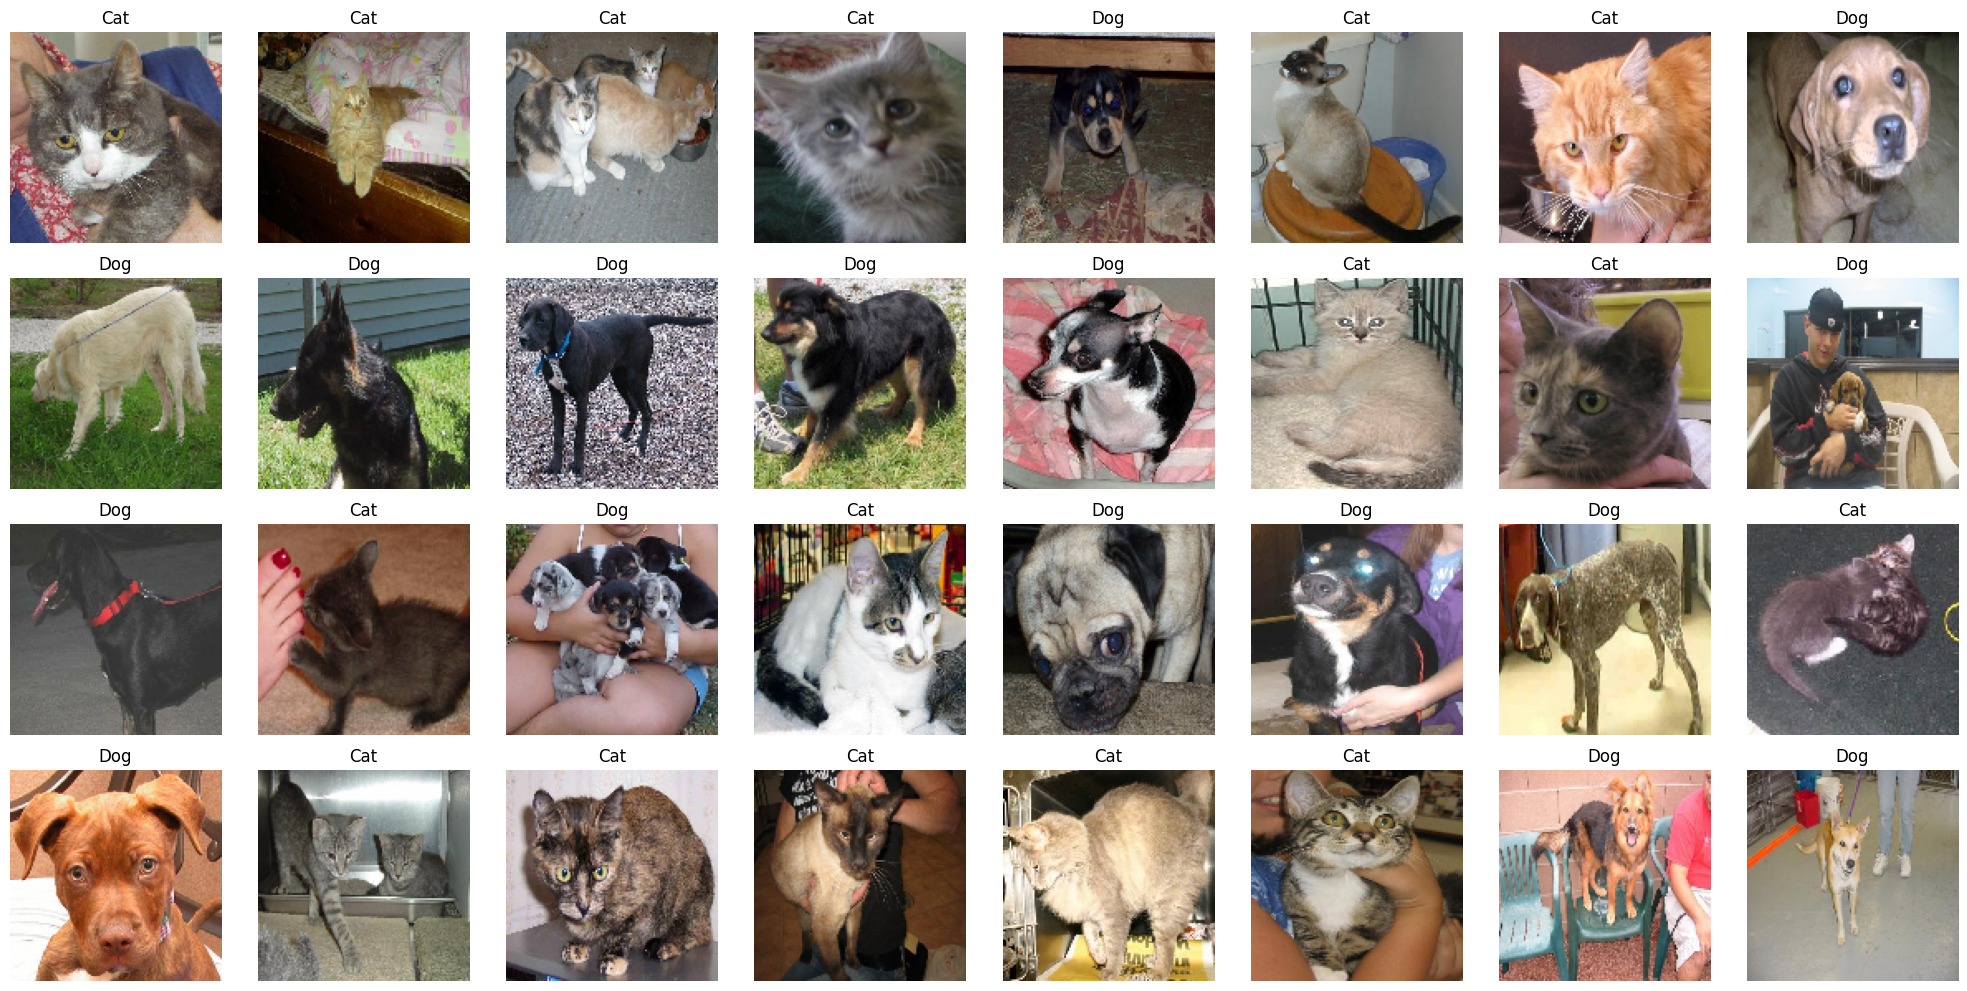

In [9]:
plt.figure(figsize=(20, 10))

#for images, labels in train_ds.take(1):
for i, (images, labels) in enumerate(zip(train_images[:BATCH_SIZE,:,:,:], train_labels[:BATCH_SIZE])):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images.astype("uint8"))
    plt.title(CLASSES[int(labels)])
    plt.axis("off")
plt.tight_layout()

## Data augmentation

Aplicamos algunas transformaciones para distorsionar un poco las imágenes de entrenamiento aleatoreamente, esto puede ayudar a generalizar el modelo. Se pueden chequear las transformaciones disponibles para TensorFlow en [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments).

Las transformaciones no deben ser "exageradas" de modo tal de no distorsionar demasiado las imágenes y "pierdan" sentido.

In [49]:
data_augmentation = Sequential([
    layers.InputLayer(shape=IMG_SHAPE),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast((0.2,1.5))
],name="Data_Augmentation")

# CNN Models

## Baseline Model

Comenzamos con un modelo simple con la intención de tener alguna noción de la performance que podemos obtener.

Con los resultados de este modelo podemos intentar mejorar las métricas cambiando hyperparámetros y/o probando modelos diferentes.

La capa GlobalAveragePooling2D toma cada mapa de activación de la última capa convolucional y calcula el promedio de todos sus valores espaciales (alto y ancho), reduciéndolo a un solo valor por canal. Así, transforma un tensor de forma (alto, ancho, canales) en un vector de tamaño (canales).

¿Para qué sirve?

- Reduce la dimensionalidad de los datos antes de las capas densas.
- Disminuye el riesgo de sobreajuste, ya que tiene menos parámetros que una capa Flatten.
- Resume la información espacial de cada canal en un solo número, manteniendo la información más relevante.

Ejemplo: Si la salida de la última convolución es (4, 4, 128), la capa GlobalAveragePooling2D la convierte en (128,), promediando cada uno de los 128 mapas de activación.


La capa MaxPooling2D reduce la dimensión espacial (alto y ancho) de los mapas de activación de una imagen, tomando el valor máximo en cada ventana (por ejemplo, de 2x2 píxeles) y desplazándose por la imagen. Esto ayuda a:

Reducir la cantidad de parámetros y el costo computacional.
Resumir la información más importante (el valor máximo) de cada región.
Hacer que el modelo sea más robusto a pequeñas traslaciones y distorsiones en la imagen.
En resumen, es una forma de "resumir" la información y reducir el tamaño de los datos a medida que avanzan por la red.

La capa BatchNormalization normaliza las activaciones de la capa anterior para cada mini-batch durante el entrenamiento. Esto significa que ajusta y escala los valores para que tengan media cercana a 0 y desviación estándar cercana a 1.

¿Para qué sirve?

Acelera el entrenamiento de la red.
Ayuda a estabilizar el aprendizaje.
Reduce el problema de desvanecimiento/explosión del gradiente.
Puede actuar como una forma ligera de regularización.
Se suele colocar después de una capa convolucional o densa y antes de la función de activación.

In [16]:
MODEL_NAME = "Baseline_CNN"

#Definimos el modelo
model = Sequential([
  layers.InputLayer(shape=IMG_SHAPE), # Capa de entrada con las dimensiones de la imagen
  layers.Rescaling(1./255), # Normalización de las imágenes
  data_augmentation, # Aplicamos las transformaciones de data augmentation
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'), # Capa convolucional con 16 filtros, tamaño de kernel 3x3, padding 'same' y activación ReLU
  layers.MaxPooling2D(), # Capa de max pooling para reducir la dimensionalidad
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'), # Capa convolucional con 32 filtros
  layers.MaxPooling2D(), # Otra capa de max pooling
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'), # Capa convolucional con 64 filtros
  layers.MaxPooling2D(), # Otra capa de max pooling
  layers.Flatten(), # Aplanamiento de las salidas de la capa convolucional para conectarlas a capas densas
  layers.Dense(256, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'), # Capa densa con 256 neuronas y activación ReLU
  layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros') # Capa de salida con una neurona y activación sigmoide para clasificación binaria
], name=MODEL_NAME)

model.summary();

Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,401 (16.09 MB)

 Trainable params: 4,218,401 (16.09 MB)

 Non-trainable params: 0 (0.00 B)

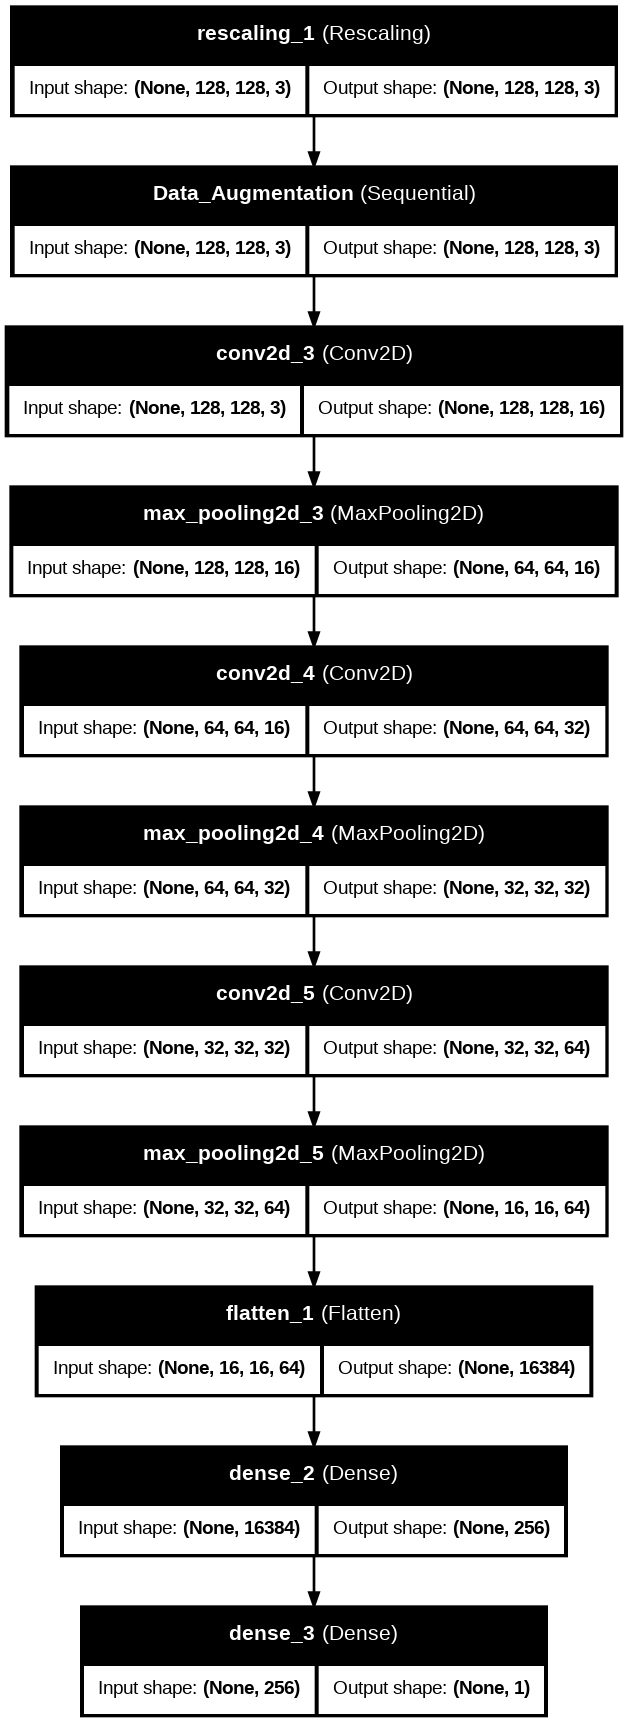

In [17]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [18]:
# Comienza con una tasa de aprendizaje de 0.0001 y 100 épocas de entrenamiento
LEARNING_RATE = 0.0001
EPOCHS = 100

# Define el optimizador, la función de pérdida y las métricas
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]

# Compila el modelo con el optimizador, la función de pérdida y las métricas
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [19]:
# Define un callback para detener el entrenamiento temprano si la pérdida de validación no mejora durante 10 épocas
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,
    verbose = 1
)

In [20]:
# Entrena el modelo utilizando el conjunto de entrenamiento y validación
# El entrenamiento se realiza durante un número fijo de épocas (EPOCHS) y se utiliza
# un número limitado de lotes de entrenamiento (NBATCHES) para acelerar el proceso.
# El modelo se ajusta a los datos de entrenamiento y se valida en los datos de validación.
# Se utilizan callbacks para monitorear el entrenamiento y detenerlo si la pérdida de validación
# no mejora durante un número determinado de épocas (patience).

history = model.fit(
    train_images, train_labels,
    validation_data = (val_images, val_labels),
    callbacks = [callbacks],
    epochs = EPOCHS,
    verbose = 1
  )

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - Precision: 0.5475 - Recall: 0.5749 - accuracy: 0.5504 - loss: 0.8435 - val_Precision: 0.7249 - val_Recall: 0.5661 - val_accuracy: 0.6707 - val_loss: 0.6260
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - Precision: 0.6348 - Recall: 0.6321 - accuracy: 0.6347 - loss: 0.6387 - val_Precision: 0.6539 - val_Recall: 0.7916 - val_accuracy: 0.6816 - val_loss: 0.6038
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - Precision: 0.6709 - Recall: 0.6573 - accuracy: 0.6678 - loss: 0.6108 - val_Precision: 0.6696 - val_Recall: 0.8056 - val_accuracy: 0.6996 - val_loss: 0.5895
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - Precision: 0.6821 - Recall: 0.6682 - accuracy: 0.6787 - loss: 0.5965 - val_Precision: 0.7144 - val_Recall: 0.7605 - val_accuracy: 0.7241 - val_loss: 0.5672
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - Precision: 0.7085 - Recall: 0.6815 - accuracy: 0.7009 - loss: 0.5789 - val_Precision: 0.7287 -

### Resultados en datos de validación y de test

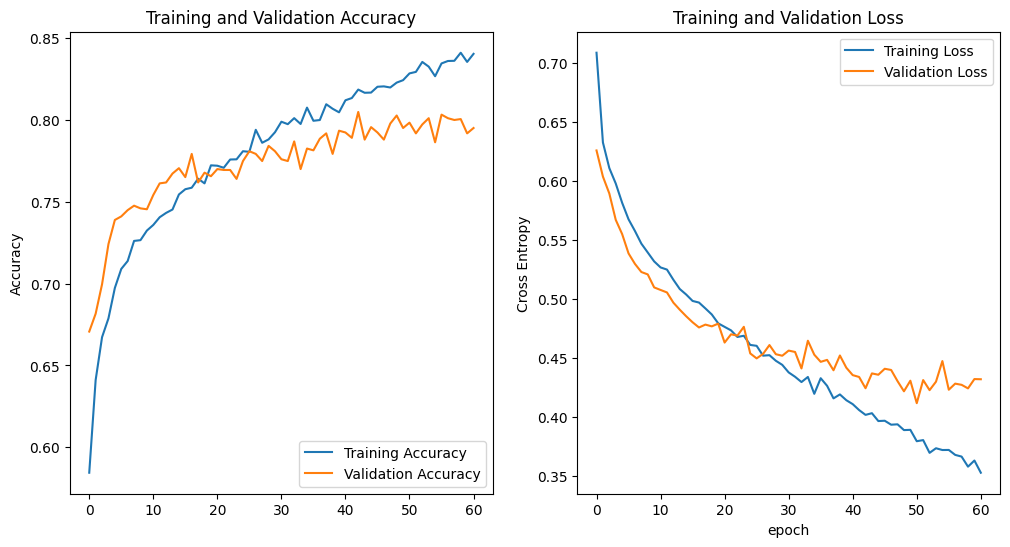

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.77      0.82      0.80       907
         Dog       0.81      0.77      0.79       922

    accuracy                           0.79      1829
   macro avg       0.79      0.79      0.79      1829
weighted avg       0.79      0.79      0.79      1829


Confusion Matrix on Test Data 1
     0    1
0  741  166
1  216  706


In [23]:
plot_history(history)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [25]:
results = save_results(model, y_true, y_pred, results)

## Baseline model con dropout

Si notamos que ocurre algo de sobreajuste (*overfitting*) del conjunto de entrenamiento, podemos agregar una capa de *Dropout* para intentar evitarlo.

Agreguemos una capa de *Dropout* del 30% antes de la capa de aplanamiento.

In [31]:
MODEL_NAME = "Baseline_CNN_with_Dropout"

# Definimos el modelo
model = Sequential([
  layers.InputLayer(shape=IMG_SHAPE), # Capa de entrada con las dimensiones de la imagen
  layers.Rescaling(1./255), # Normalización de las imágenes
  data_augmentation, # Aplicamos las transformaciones de data augmentation
  layers.Conv2D(16, 3, padding='same', activation='relu'),  #Add kernel_initializer and bias_initializer
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),  #Add kernel_initializer and bias_initializer
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),  #Add kernel_initializer and bias_initializer
  layers.MaxPooling2D(),
  layers.Dropout(0.3),   # Add Dropout layer
  layers.Flatten(),
  layers.Dense(256, activation='relu'), #Add kernel_initializer and bias_initializer
  layers.Dense(1, activation='sigmoid') #Add kernel_initializer and bias_initializer
], name=MODEL_NAME)

model.summary()

Model: "Baseline_CNN_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,401 (16.09 MB)

 Trainable params: 4,218,401 (16.09 MB)

 Non-trainable params: 0 (0.00 B)

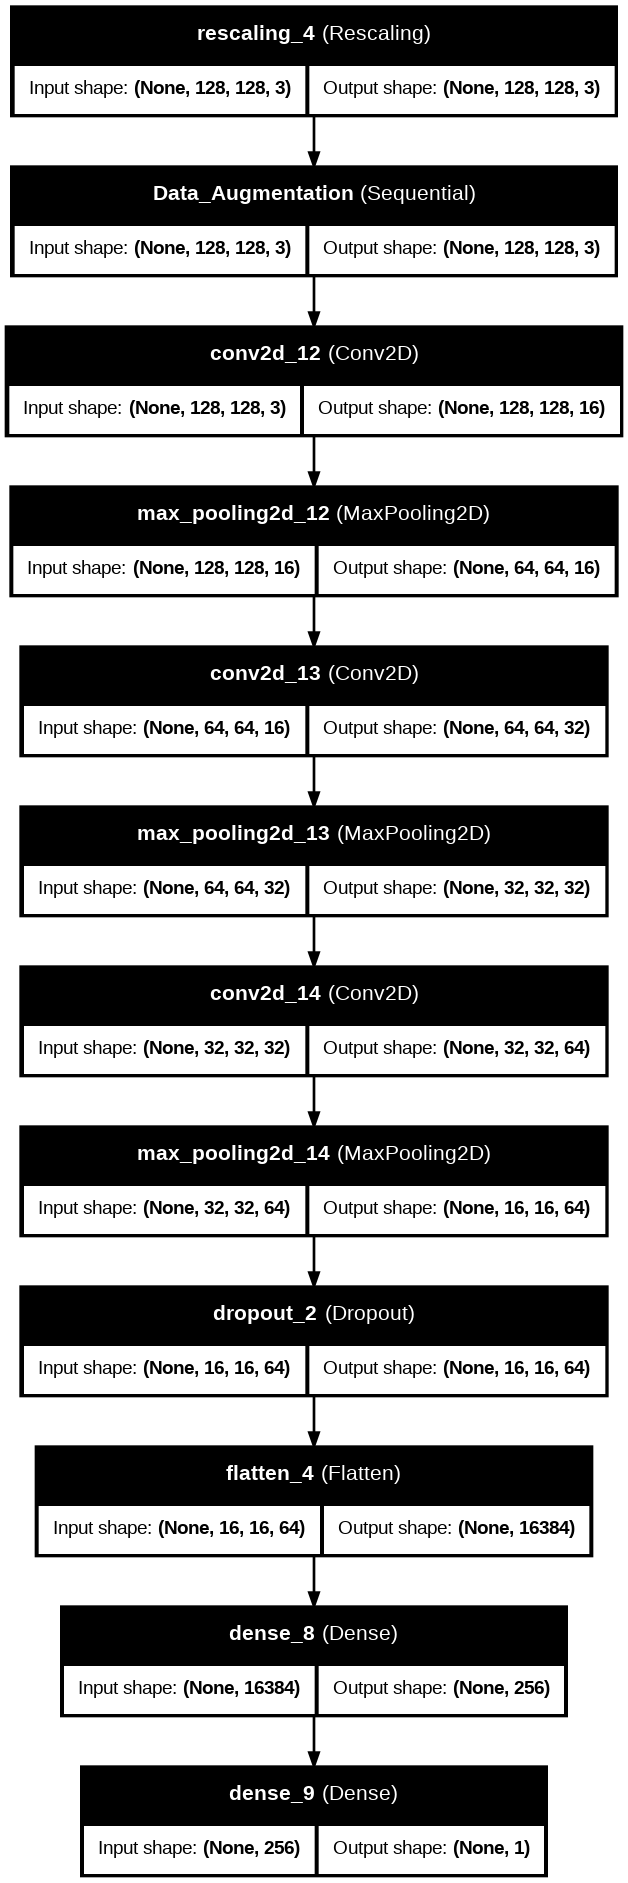

In [33]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [34]:
#compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

#fit the model
history = model.fit(
  train_images, train_labels,
  validation_data = (val_images, val_labels),
  callbacks = [callbacks],
  epochs = EPOCHS,
  verbose = 1
)

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - Precision: 0.5478 - Recall: 0.6325 - accuracy: 0.5576 - loss: 0.6777 - val_Precision: 0.6734 - val_Recall: 0.7175 - val_accuracy: 0.6799 - val_loss: 0.6082
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - Precision: 0.6863 - Recall: 0.6330 - accuracy: 0.6718 - loss: 0.6141 - val_Precision: 0.6948 - val_Recall: 0.7680 - val_accuracy: 0.7110 - val_loss: 0.5765
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - Precision: 0.6976 - Recall: 0.6667 - accuracy: 0.6892 - loss: 0.5852 - val_Precision: 0.7387 - val_Recall: 0.7379 - val_accuracy: 0.7345 - val_loss: 0.5543
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - Precision: 0.7162 - Recall: 0.6759 - accuracy: 0.7043 - loss: 0.5674 - val_Precision: 0.7157 - val_Recall: 0.7734 - val_accuracy: 0.7290 - val_loss: 0.5421
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - Precision: 0.7336 - Recall: 0.6948 - accuracy: 0.7214 - loss: 0.5568 - val_Precision: 0.7599 

### Resultados en datos de validación y de test

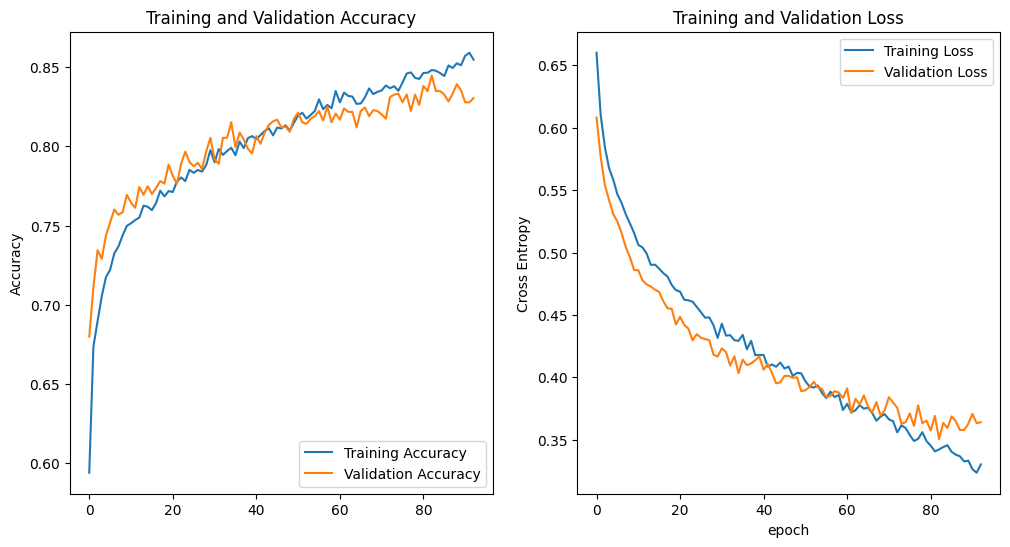

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.84      0.84      0.84       907
         Dog       0.84      0.84      0.84       922

    accuracy                           0.84      1829
   macro avg       0.84      0.84      0.84      1829
weighted avg       0.84      0.84      0.84      1829


Confusion Matrix on Test Data 1
     0    1
0  764  143
1  148  774


In [35]:
plot_history(history)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [36]:
results = save_results(model, y_true, y_pred, results)

## Resnet 50

Ahora emplearemos un modelo pre-entrenado para aplicar *transfer learning*, comenzaremos con una Residual Network 50

In [37]:
MODEL_NAME = "RESNET_50"
LEARNING_RATE = 0.0001
INITIAL_EPOCH = 30

# Cargamos el modelo base de ResNet50 con pesos preentrenados en ImageNet
# y lo adaptamos a nuestro problema de clasificación binaria
base_model = tf.keras.applications.ResNet50(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')

# Congelamos las capas del modelo base (para evitar que se actualicen los pesos durante el entrenamiento)
base_model.trainable = False

base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [50]:
# Agregamos capas adicionales al modelo base
# para adaptarlo a nuestro problema de clasificación binaria
# La capa de GlobalAveragePooling2D reduce la dimensionalidad de las características extraídas
# La capa de Dense es la capa de salida que produce la predicción final
# La capa de Dropout se utiliza para evitar el sobreajuste
# La capa de Dense es la capa de salida que produce la predicción final

inputs = layers.Input(shape = IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x) # Preprocesamiento de la imagen
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs, name = MODEL_NAME)

model.summary();

Model: "RESNET_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Data_Augmentation   │ (None, 128, 128,  │          0 │ input_layer_16[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]
model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

In [52]:
history = model.fit(
    train_images, train_labels,
    validation_data = (val_images, val_labels),
    callbacks = [callbacks],
    epochs = INITIAL_EPOCH,
    verbose = 1
)

Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - Precision: 0.7861 - Recall: 0.7783 - accuracy: 0.7852 - loss: 0.7171 - val_Precision: 0.9485 - val_Recall: 0.9689 - val_accuracy: 0.9575 - val_loss: 0.1392
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - Precision: 0.8665 - Recall: 0.8738 - accuracy: 0.8697 - loss: 0.3999 - val_Precision: 0.9597 - val_Recall: 0.9731 - val_accuracy: 0.9656 - val_loss: 0.1147
Epoch 3/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - Precision: 0.8801 - Recall: 0.8834 - accuracy: 0.8817 - loss: 0.3601 - val_Precision: 0.9273 - val_Recall: 0.9871 - val_accuracy: 0.9542 - val_loss: 0.1783
Epoch 4/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - Precision: 0.8834 - Recall: 0.8931 - accuracy: 0.8877 - loss: 0.3642 - val_Precision: 0.9549 - val_Recall: 0.9785 - val_accuracy: 0.9656 - val_loss: 0.1183
Epoch 5/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - Precision: 0.9010 - Recall: 0.8919 - accuracy: 0.8971 - loss: 0.3169 - val_Precision: 0.9246 - v

### Resultados en datos de validación y de test

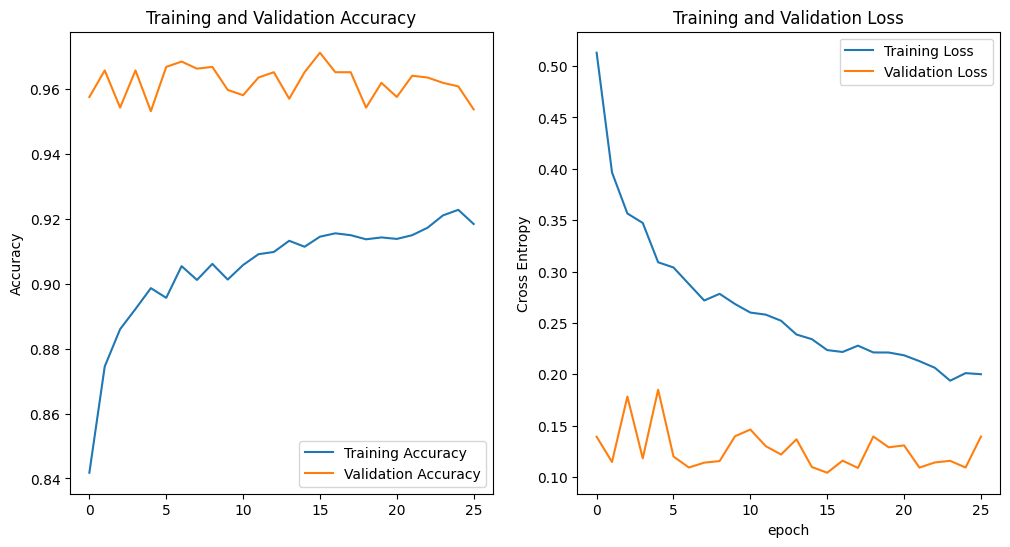

58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.97      0.96      0.97       907
         Dog       0.96      0.97      0.97       922

    accuracy                           0.97      1829
   macro avg       0.97      0.97      0.97      1829
weighted avg       0.97      0.97      0.97      1829


Confusion Matrix on Test Data 1
     0    1
0  872   35
1   28  894


In [53]:
plot_history(history)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [ ]:
results = save_results(model, y_true, y_pred, results)

## Restnet 50 tuning

Otra opción que podemos experimentar es dejando las primeras capas convolucionaes congeladas, y entrenar las N-últimas (por ejemplo, las 100 últimas).

In [54]:
MODEL_NAME = "RESNET_50_tuned"
LEARNING_RATE = 0.0001/10
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS =  INITIAL_EPOCH + FINE_TUNE_EPOCHS

base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.name = MODEL_NAME
model.summary();

Model: "RESNET_50_tuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Data_Augmentation   │ (None, 128, 128,  │          0 │ input_layer_16[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,162,117 (95.99 MB)

 Trainable params: 19,977,729 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

 Optimizer params: 1,049,604 (4.00 MB)

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

history2 = model.fit(
    train_images, train_labels,
    validation_data = (val_images, val_labels),
    callbacks = callbacks,
    initial_epoch = history.epoch[-1],
    epochs = TOTAL_EPOCHS,
    verbose = 1
)

Epoch 26/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 64s 144ms/step - Precision: 0.8758 - Recall: 0.8658 - accuracy: 0.8718 - loss: 0.2800 - val_Precision: 0.9497 - val_Recall: 0.9731 - val_accuracy: 0.9602 - val_loss: 0.1034
Epoch 27/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - Precision: 0.9123 - Recall: 0.9052 - accuracy: 0.9091 - loss: 0.2151 - val_Precision: 0.9615 - val_Recall: 0.9646 - val_accuracy: 0.9624 - val_loss: 0.0919
Epoch 28/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - Precision: 0.9229 - Recall: 0.9134 - accuracy: 0.9185 - loss: 0.1878 - val_Precision: 0.9568 - val_Recall: 0.9753 - val_accuracy: 0.9651 - val_loss: 0.0856
Epoch 29/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - Precision: 0.9305 - Recall: 0.9183 - accuracy: 0.9250 - loss: 0.1719 - val_Precision: 0.9608 - val_Recall: 0.9742 - val_accuracy: 0.9667 - val_loss: 0.0852
Epoch 30/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - Precision: 0.9418 - Recall: 0.9395 - accuracy: 0.9408 - loss: 0.1443 - val_Precis

### Resultados en datos de validación y de test

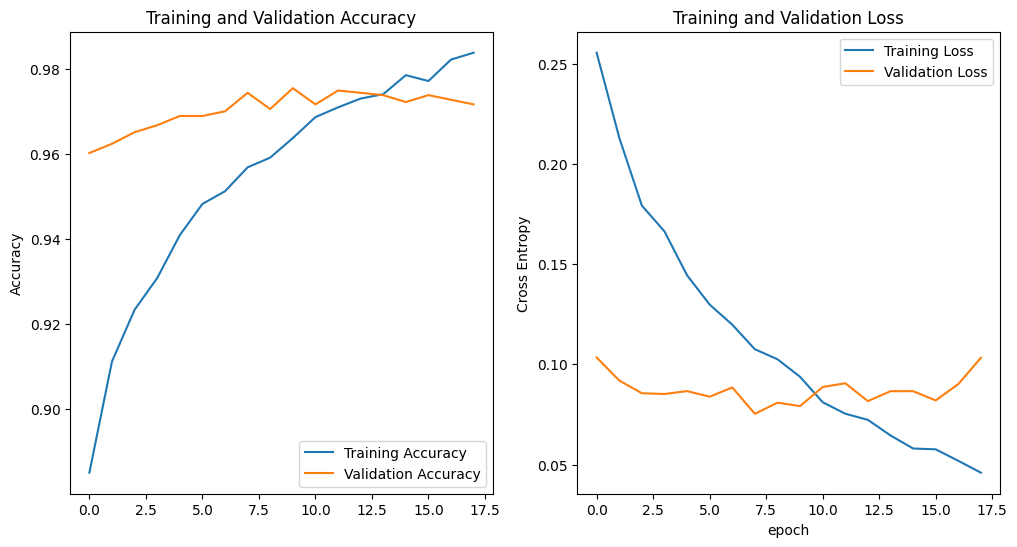

58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.97      0.95      0.96       907
         Dog       0.95      0.97      0.96       922

    accuracy                           0.96      1829
   macro avg       0.96      0.96      0.96      1829
weighted avg       0.96      0.96      0.96      1829


Confusion Matrix on Test Data 1
     0    1
0  861   46
1   27  895


In [56]:
plot_history(history2)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [57]:
results = save_results(model, y_true, y_pred, results)

## Resnet 50 Tunning and Decaying Learning Rate

A veces puede resultar útil que el paso de entrenamiento sea grande al inicio y luego vaya disminuyendo a medida que van avanzando las épocas de entrenamiento.

In [58]:
MODEL_NAME = "RESNET_50_Tuned_with_Decay_LR"
INITIAL_LEARNING_RATE =  0.00001
FINAL_LEARNING_RATE = INITIAL_LEARNING_RATE/10
LEARNING_RATE_DECAY_FACTOR = (FINAL_LEARNING_RATE / INITIAL_LEARNING_RATE)**(1/FINE_TUNE_EPOCHS)
STEPS_PER_EPOCH = int(10000/32)  #train size / batch size

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=INITIAL_LEARNING_RATE,
                decay_steps=STEPS_PER_EPOCH,
                decay_rate=LEARNING_RATE_DECAY_FACTOR,
                staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.name = MODEL_NAME

model.summary();


Model: "RESNET_50_Tuned_with_Decay_LR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Data_Augmentation   │ (None, 128, 128,  │          0 │ input_layer_16[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ Data_Augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 19,977,729 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [60]:
history2 = model.fit(
    train_images, train_labels,
    validation_data = (val_images, val_labels),
    callbacks = callbacks,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    verbose = 1
)

Epoch 26/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 62s 142ms/step - Precision: 0.9649 - Recall: 0.9592 - accuracy: 0.9622 - loss: 0.1002 - val_Precision: 0.9662 - val_Recall: 0.9839 - val_accuracy: 0.9744 - val_loss: 0.0804
Epoch 27/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - Precision: 0.9676 - Recall: 0.9721 - accuracy: 0.9697 - loss: 0.0826 - val_Precision: 0.9592 - val_Recall: 0.9860 - val_accuracy: 0.9716 - val_loss: 0.0835
Epoch 28/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 45s 142ms/step - Precision: 0.9660 - Recall: 0.9676 - accuracy: 0.9668 - loss: 0.0859 - val_Precision: 0.9662 - val_Recall: 0.9817 - val_accuracy: 0.9733 - val_loss: 0.0871
Epoch 29/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - Precision: 0.9726 - Recall: 0.9711 - accuracy: 0.9719 - loss: 0.0725 - val_Precision: 0.9610 - val_Recall: 0.9785 - val_accuracy: 0.9689 - val_loss: 0.0873
Epoch 30/130
273/273 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - Precision: 0.9705 - Recall: 0.9691 - accuracy: 0.9699 - loss: 0.0704 - val_Precis

### Resultados en datos de validación y de test

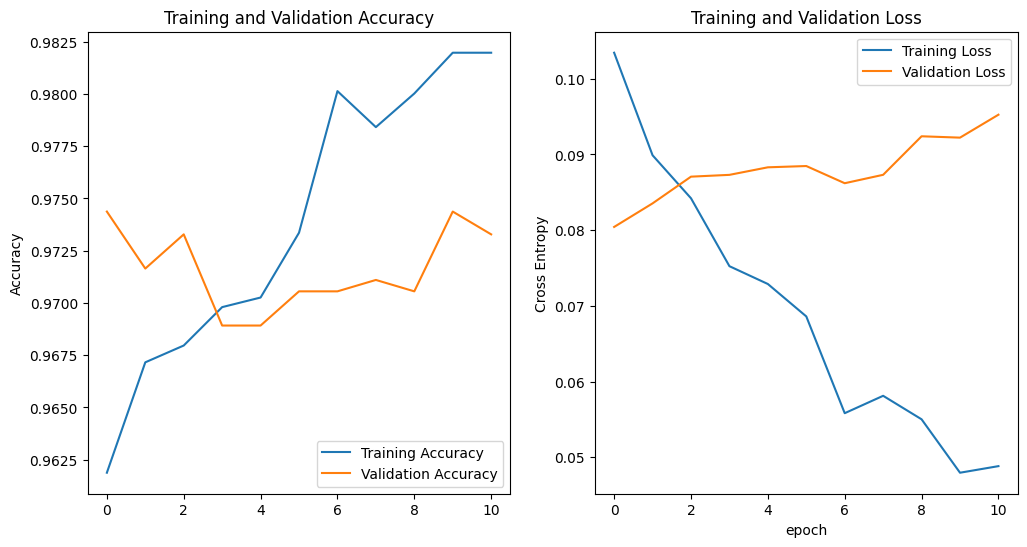

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.98      0.95      0.96       907
         Dog       0.95      0.98      0.97       922

    accuracy                           0.96      1829
   macro avg       0.96      0.96      0.96      1829
weighted avg       0.96      0.96      0.96      1829


Confusion Matrix on Test Data 1
     0    1
0  862   45
1   20  902


In [61]:
plot_history(history2)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [62]:
results = save_results(model, y_true, y_pred, results)

In [64]:
results

model  accuracy      loss    recall  precision
0                   Baseline_CNN  0.791143  0.434770  0.765727   0.809633
1      Baseline_CNN_with_Dropout  0.840897  0.368011  0.839479   0.844057
2                RESNET_50_tuned  0.960087  0.118153  0.970716   0.951116
3  RESNET_50_Tuned_with_Decay_LR  0.964461  0.121837  0.978308   0.952482

## Mobile Net Model

Aqui emplemos otro modelo de CNN que resulta bastante más liviano que ResNet50, en particular este fue pensado para ser utilizado en dispositivos móviles.

In [65]:
MODEL_NAME = "MOBILE_NET"
LEARNING_RATE = 0.0001
INITIAL_EPOCH = 50

# Creamos el modelo base a partir del modelo preentrenado MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.name = MODEL_NAME

model.summary();

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MOBILE_NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

history = model.fit(
    train_images, train_labels,
    validation_data = (val_images, val_labels),
    callbacks = [callbacks],
    epochs = INITIAL_EPOCH,
    verbose = 1
)


Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - Precision: 0.6226 - Recall: 0.3773 - accuracy: 0.5761 - loss: 5.3170 - val_Precision: 0.8276 - val_Recall: 0.6756 - val_accuracy: 0.7639 - val_loss: 2.2103
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - Precision: 0.6703 - Recall: 0.6173 - accuracy: 0.6575 - loss: 4.0667 - val_Precision: 0.8667 - val_Recall: 0.7755 - val_accuracy: 0.8255 - val_loss: 1.6380
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - Precision: 0.6760 - Recall: 0.6933 - accuracy: 0.6809 - loss: 3.5693 - val_Precision: 0.8941 - val_Recall: 0.8249 - val_accuracy: 0.8615 - val_loss: 1.3096
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - Precision: 0.7542 - Recall: 0.6751 - accuracy: 0.7279 - loss: 3.1687 - val_Precision: 0.9003 - val_Recall: 0.8733 - val_accuracy: 0.8866 - val_loss: 1.1530
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - Precision: 0.7015 - Recall: 0.8098 - accuracy: 0.7334 - loss: 3.1294 - val_Precision: 0.8789 - va

### Resultados en datos de validación y de test

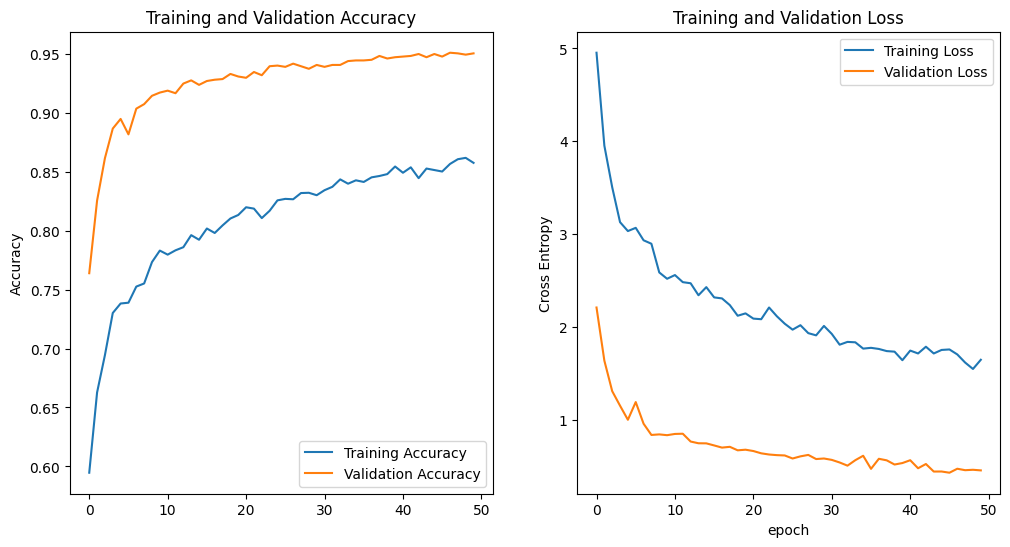

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.95      0.96      0.95       907
         Dog       0.96      0.95      0.95       922

    accuracy                           0.95      1829
   macro avg       0.95      0.95      0.95      1829
weighted avg       0.95      0.95      0.95      1829


Confusion Matrix on Test Data 1
     0    1
0  873   34
1   50  872


In [67]:
plot_history(history)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [68]:
results = save_results(model, y_true, y_pred, results)

## Mobile Net Model Tunning

In [69]:
MODEL_NAME = "MOBILE_NET_Tuned"
LEARNING_RATE = 0.0001/10
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS =  INITIAL_EPOCH + FINE_TUNE_EPOCHS

base_model.trainable = True

# Define la capa a partir de la cual se realizará el fine-tuning
fine_tune_at = 100

# Congelamos las capas del modelo base hasta la capa fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
model.name = MODEL_NAME

model.summary();

Model: "MOBILE_NET_Tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2,564 (10.02 KB)

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)


history2 = model.fit(
    train_images, train_labels,
    validation_data = (val_images, val_labels),
    callbacks = [callbacks],
    initial_epoch = history.epoch[-1],
    epochs = TOTAL_EPOCHS,
    verbose = 1
)

Epoch 50/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - Precision: 0.7683 - Recall: 0.8607 - accuracy: 0.8005 - loss: 2.1821 - val_Precision: 0.9497 - val_Recall: 0.9538 - val_accuracy: 0.9509 - val_loss: 0.4879
Epoch 51/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - Precision: 0.8035 - Recall: 0.8630 - accuracy: 0.8261 - loss: 1.8889 - val_Precision: 0.9440 - val_Recall: 0.9603 - val_accuracy: 0.9509 - val_loss: 0.5360
Epoch 52/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - Precision: 0.8168 - Recall: 0.8507 - accuracy: 0.8301 - loss: 1.9401 - val_Precision: 0.9433 - val_Recall: 0.9646 - val_accuracy: 0.9526 - val_loss: 0.4876
Epoch 53/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - Precision: 0.8334 - Recall: 0.8631 - accuracy: 0.8453 - loss: 1.6811 - val_Precision: 0.9671 - val_Recall: 0.9463 - val_accuracy: 0.9564 - val_loss: 0.4416
Epoch 54/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - Precision: 0.8407 - Recall: 0.8690 - accuracy: 0.8522 - loss: 1.6173 - val_Precision: 

### Resultados en datos de validación y de test

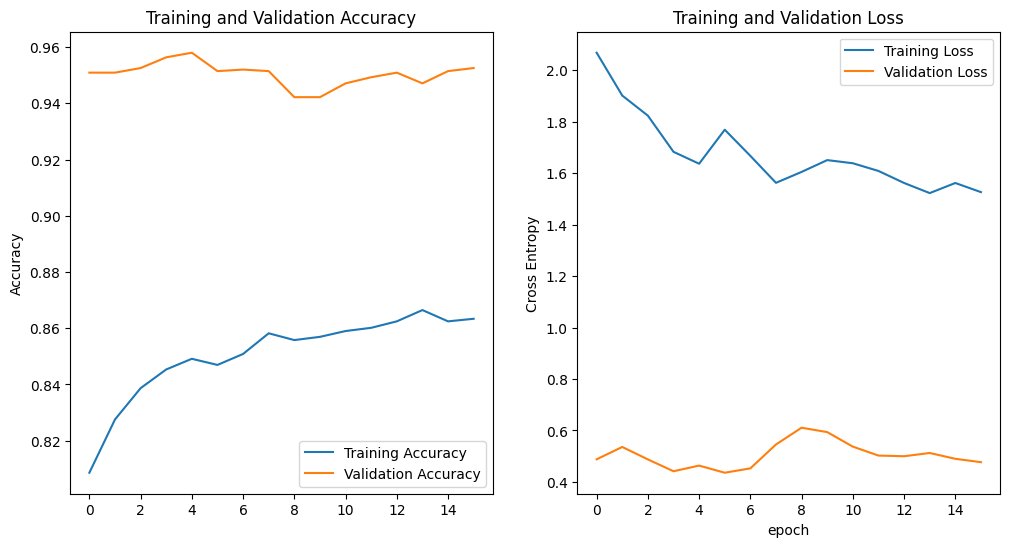

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.98      0.94      0.96       907
         Dog       0.94      0.98      0.96       922

    accuracy                           0.96      1829
   macro avg       0.96      0.96      0.96      1829
weighted avg       0.96      0.96      0.96      1829


Confusion Matrix on Test Data 1
     0    1
0  851   56
1   21  901


In [71]:
plot_history(history2)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [72]:
results = save_results(model, y_true, y_pred, results)

## Mobile Net Model Tunning and Decaying Learning Rate

In [73]:
MODEL_NAME = "MOBILE_NET_Tuned_with_Decay_LR"
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS =  INITIAL_EPOCH + FINE_TUNE_EPOCHS
INITIAL_LEARNING_RATE =  0.00001
FINAL_LEARNING_RATE = INITIAL_LEARNING_RATE/10
LEARNING_RATE_DECAY_FACTOR = (FINAL_LEARNING_RATE / INITIAL_LEARNING_RATE)**(1/FINE_TUNE_EPOCHS)
STEPS_PER_EPOCH = int(10000/32)  #train size / batch size

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=INITIAL_LEARNING_RATE,
                decay_steps=STEPS_PER_EPOCH,
                decay_rate=LEARNING_RATE_DECAY_FACTOR,
                staircase=True)
model.name = MODEL_NAME

model.summary()

Model: "MOBILE_NET_Tuned_with_Decay_LR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,984,709 (22.83 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,725,444 (14.21 MB)

In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', "Recall", "Precision"]
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

history2 = model.fit(
    train_images, train_labels,
    validation_data = (val_images, val_labels),
    callbacks=[callbacks],
    epochs=TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    verbose=1
)

Epoch 50/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - Precision: 0.8387 - Recall: 0.8706 - accuracy: 0.8516 - loss: 1.6630 - val_Precision: 0.9378 - val_Recall: 0.9721 - val_accuracy: 0.9531 - val_loss: 0.5012
Epoch 51/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - Precision: 0.8620 - Recall: 0.8733 - accuracy: 0.8667 - loss: 1.5006 - val_Precision: 0.9406 - val_Recall: 0.9699 - val_accuracy: 0.9537 - val_loss: 0.4495
Epoch 52/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - Precision: 0.8704 - Recall: 0.8583 - accuracy: 0.8654 - loss: 1.4561 - val_Precision: 0.9484 - val_Recall: 0.9667 - val_accuracy: 0.9564 - val_loss: 0.4599
Epoch 53/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - Precision: 0.8886 - Recall: 0.8522 - accuracy: 0.8728 - loss: 1.4351 - val_Precision: 0.9494 - val_Recall: 0.9667 - val_accuracy: 0.9569 - val_loss: 0.4594
Epoch 54/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - Precision: 0.8878 - Recall: 0.8669 - accuracy: 0.8786 - loss: 1.3701 - val_Precision: 

### Resultados en datos de validación y de test

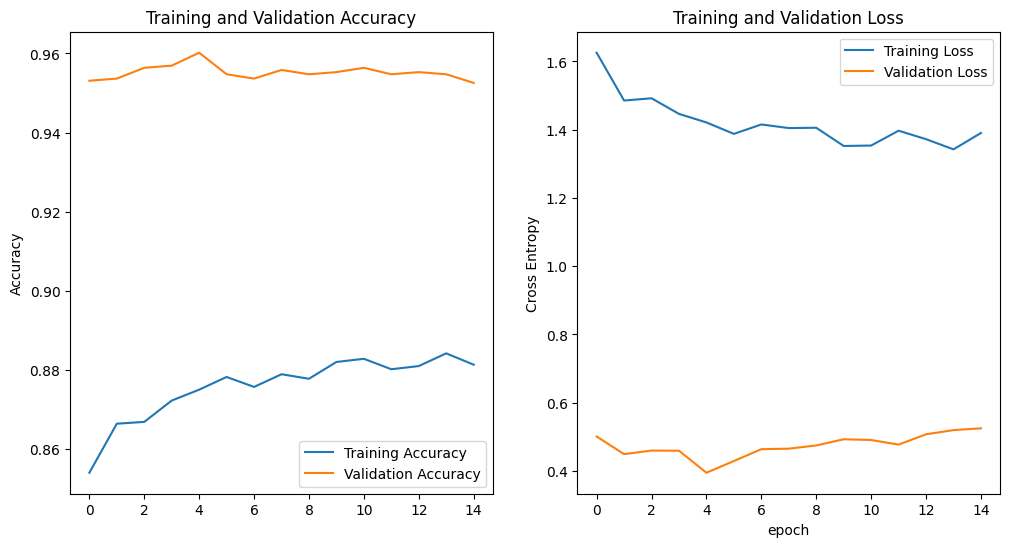

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step
Classification Report on Test Data 1
              precision    recall  f1-score   support

         Cat       0.96      0.96      0.96       907
         Dog       0.96      0.96      0.96       922

    accuracy                           0.96      1829
   macro avg       0.96      0.96      0.96      1829
weighted avg       0.96      0.96      0.96      1829


Confusion Matrix on Test Data 1
     0    1
0  872   35
1   34  888


In [75]:
plot_history(history2)
y_true, y_pred = get_predictions(model, test_images, test_labels)
plot_confusion_matrix(y_true, y_pred, CLASSES)

In [76]:
results = save_results(model, y_true, y_pred, results)

# Resultados: Comparación de los modelos

In [77]:
results.sort_values(by = "accuracy", ascending = False)
results

model  accuracy      loss    recall  precision
0                    Baseline_CNN  0.791143  0.434770  0.765727   0.809633
1       Baseline_CNN_with_Dropout  0.840897  0.368011  0.839479   0.844057
2                 RESNET_50_tuned  0.960087  0.118153  0.970716   0.951116
3   RESNET_50_Tuned_with_Decay_LR  0.964461  0.121837  0.978308   0.952482
4                      MOBILE_NET  0.954073  0.449638  0.945770   0.962472
5                MOBILE_NET_Tuned  0.957900  0.433544  0.977223   0.941484
6  MOBILE_NET_Tuned_with_Decay_LR  0.962274  0.419098  0.963124   0.962080

# Entregable

Aquí los [DATOS](https://drive.google.com/drive/folders/1zhE0f7SS9bdLMXkJGpfja-ZBf5uwZpsZ?usp=drive_link)

Los datos son imágenes satelitales de Texas después del huracán Harvey, divididas en dos grupos (daño y sin daño). El objetivo es crear un modelo que pueda identificar automáticamente si una región determinada probablemente contiene daños por inundación.

**Fuente**

- Building Damage Annotation on Post-Hurricane Satellite Imagery Based on Convolutional Neural Networks, Quoc Dung Cao, Youngjun Choe
- Datos tomados originalmente de: https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized y pueden citarse con http://dx.doi.org/10.21227/sdad-1e56. El artículo original está disponible en: https://arxiv.org/abs/1807.01688

**Tareas**

- Realizar una inspección visual de algunos ejemplos de los datos y sus etiquetas, analizar el (des)balance de las clases, determinar el tamaño de las imágenes, el formato en que se encuentran almacenadas, etc.

- Elegir al menos 3 configuraciones de redes neuronales convolucionales (pueden ser las vistas durante esta notebook) y comparar los resultados en término de las métricas elegidas, considerar en la comparación la cantidad de parámetros y el tiempo de computo consumido para su entrenamiento. Resumir los resultados en una tabla, y discutir cual modelo recomendaría y por qué.

- Propone y prueba una mejora sobre algunos de los modelos presentados (puede ser un cambio en la arquitectura, en el preprocesamiento, en el data augmentation, o en los hiperparámetros). Implementar el cambio y reporta los resultados obtenidos en comparación con los modelos anteriores. ¿Se obtuvo una mejora significativa?